In [1]:
import os  
import cv2  
import torch  
import random  
import numpy as np 
import matplotlib.pyplot as plt  
from tqdm import tqdm
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
config = {  
    "model_name": "resnet", 
    "num_epochs": 15,
    "batch_size": 32,
    "learning_rate": 0.001,
    "test_size": 0.2,
    "sample_ratio": 1.0
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "Aerial_Landscapes/"

In [3]:
def initialize_model(model_name, num_classes, use_pretrained=True):
    input_size = 224
    if model_name == "resnet":
        model = models.resnet18(pretrained=use_pretrained)  
        model.fc = nn.Linear(model.fc.in_features, num_classes)  
    elif model_name == "vgg":
        model = models.vgg16(pretrained=use_pretrained)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    else:
        raise ValueError("please choose resnet or vgg")
    return model, input_size

In [4]:
def get_transforms(input_size=224):
    train_transform = transforms.Compose([  
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((input_size, input_size)),
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),  
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x + 0.05 * torch.randn_like(x)),  
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([  
        transforms.ToPILImage(),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return train_transform, test_transform

In [5]:
class CustomDataset(Dataset): 
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
def load_and_split_dataset(root_dir, test_size=0.2, sample_ratio=1.0):
    classes = sorted(os.listdir(root_dir))
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    train_images, train_labels = [], []
    test_images, test_labels = [], []

    for cls_name in classes:
        cls_path = os.path.join(root_dir, cls_name)
        img_files = [os.path.join(cls_path, f) for f in os.listdir(cls_path) if f.endswith('.jpg')]
        random.seed(42)
        random.shuffle(img_files)
        n_samples = int(len(img_files) * sample_ratio)
        split = int(n_samples * (1 - test_size))
        imgs = img_files[:n_samples]
        train_imgs = imgs[:split]
        test_imgs = imgs[split:]
        train_images.extend([cv2.imread(p) for p in train_imgs])
        train_labels.extend([class_to_idx[cls_name]] * len(train_imgs))
        test_images.extend([cv2.imread(p) for p in test_imgs])
        test_labels.extend([class_to_idx[cls_name]] * len(test_imgs))

    return (train_images, train_labels), (test_images, test_labels), classes

In [7]:
from tqdm import tqdm

def train_model(model, device, train_loader, test_loader, criterion, optimizer, 
                num_epochs=25, checkpoint_path='checkpoint.pth', patience=5):

    best_acc = 0.0
    epochs_no_improve = 0
    early_stop = False
    history = {
        'train_loss': [], 'train_acc': [],
        'test_loss': [], 'test_acc': []
    }

    for epoch in range(num_epochs):
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        for batch in train_loader_tqdm:
            if early_stop:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels.data)
            total_train += labels.size(0)

        epoch_train_loss = train_loss / total_train
        epoch_train_acc = correct_train.double() / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc.item())

        model.eval()
        test_loss, correct_test, total_test = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_test += torch.sum(preds == labels.data)
                total_test += labels.size(0)

        epoch_test_loss = test_loss / total_test
        epoch_test_acc = correct_test.double() / total_test
        history['test_loss'].append(epoch_test_loss)
        history['test_acc'].append(epoch_test_acc.item())

        print(f"Epoch {epoch+1}: Train Acc={epoch_train_acc:.4f}, Test Acc={epoch_test_acc:.4f}")

        if epoch_test_acc > best_acc:
            best_acc = epoch_test_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), checkpoint_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                early_stop = True

    return model, history

In [8]:
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels)
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation='vertical', cmap='Blues')

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/15: 100%|██████████| 300/300 [00:14<00:00, 20.14batch/s]


Epoch 1: Train Acc=0.6550, Test Acc=0.7921


Epoch 2/15: 100%|██████████| 300/300 [00:14<00:00, 20.19batch/s]


Epoch 2: Train Acc=0.7642, Test Acc=0.7975


Epoch 3/15: 100%|██████████| 300/300 [00:14<00:00, 20.74batch/s]


Epoch 3: Train Acc=0.7948, Test Acc=0.8229


Epoch 4/15: 100%|██████████| 300/300 [00:14<00:00, 20.73batch/s]


Epoch 4: Train Acc=0.8226, Test Acc=0.8408


Epoch 5/15: 100%|██████████| 300/300 [00:15<00:00, 19.97batch/s]


Epoch 5: Train Acc=0.8277, Test Acc=0.8696


Epoch 6/15: 100%|██████████| 300/300 [00:13<00:00, 21.47batch/s]


Epoch 6: Train Acc=0.8448, Test Acc=0.8892


Epoch 7/15: 100%|██████████| 300/300 [00:13<00:00, 21.52batch/s]


Epoch 7: Train Acc=0.8528, Test Acc=0.8729


Epoch 8/15: 100%|██████████| 300/300 [00:14<00:00, 20.53batch/s]


Epoch 8: Train Acc=0.8664, Test Acc=0.9096


Epoch 9/15: 100%|██████████| 300/300 [00:13<00:00, 21.73batch/s]


Epoch 9: Train Acc=0.8671, Test Acc=0.8938


Epoch 10/15: 100%|██████████| 300/300 [00:13<00:00, 21.46batch/s]


Epoch 10: Train Acc=0.8724, Test Acc=0.8600


Epoch 11/15: 100%|██████████| 300/300 [00:13<00:00, 21.66batch/s]


Epoch 11: Train Acc=0.8774, Test Acc=0.9171


Epoch 12/15: 100%|██████████| 300/300 [00:14<00:00, 20.73batch/s]


Epoch 12: Train Acc=0.8814, Test Acc=0.9225


Epoch 13/15: 100%|██████████| 300/300 [00:13<00:00, 21.91batch/s]


Epoch 13: Train Acc=0.8813, Test Acc=0.9054


Epoch 14/15: 100%|██████████| 300/300 [00:13<00:00, 21.56batch/s]


Epoch 14: Train Acc=0.8854, Test Acc=0.9304


Epoch 15/15: 100%|██████████| 300/300 [00:14<00:00, 21.43batch/s]


Epoch 15: Train Acc=0.8847, Test Acc=0.9254
Evaluation Metrics (Precision, Recall, F1-score):

              precision    recall  f1-score   support

 Agriculture     0.9162    0.9563    0.9358       160
     Airport     0.8343    0.9125    0.8716       160
       Beach     0.9863    0.9000    0.9412       160
        City     0.9658    0.8812    0.9216       160
      Desert     0.9554    0.9375    0.9464       160
      Forest     0.9634    0.9875    0.9753       160
   Grassland     0.9801    0.9250    0.9518       160
     Highway     0.8736    0.9500    0.9102       160
        Lake     0.9452    0.8625    0.9020       160
    Mountain     0.9419    0.9125    0.9270       160
     Parking     0.9632    0.9812    0.9721       160
        Port     0.9748    0.9688    0.9718       160
     Railway     0.9394    0.7750    0.8493       160
 Residential     0.9294    0.9875    0.9576       160
       River     0.7744    0.9437    0.8507       160

    accuracy                         0.

<Figure size 1200x1000 with 0 Axes>

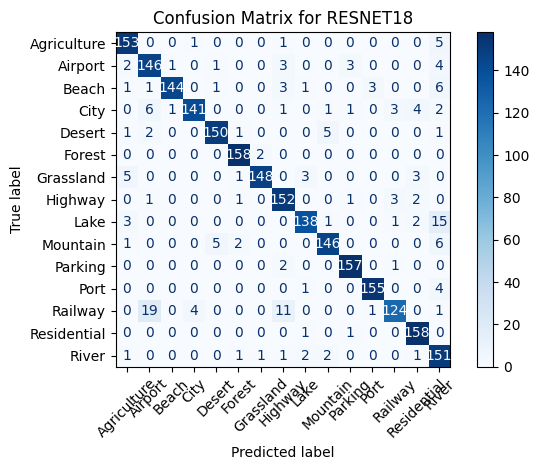

In [9]:
(train_images, train_labels), (test_images, test_labels), classes = load_and_split_dataset(
    dataset_path,
    test_size=config["test_size"], 
    sample_ratio=config["sample_ratio"]  
)

model, input_size = initialize_model(
    model_name=config["model_name"], 
    num_classes=len(classes),
    use_pretrained=True
)
model = model.to(device)

train_transform, test_transform = get_transforms(input_size)

train_dataset = CustomDataset(train_images, train_labels, train_transform)
test_dataset = CustomDataset(test_images, test_labels, test_transform)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)  
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False) 

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])  

model, history = train_model(
    model, device, train_loader, test_loader,
    criterion, optimizer,
    num_epochs=config["num_epochs"], 
    patience=5
)

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels)
        y_pred.extend(preds.cpu().numpy())

report = classification_report(y_true, y_pred, target_names=classes, digits=4)
print("Evaluation Metrics (Precision, Recall, F1-score):\n")
print(report)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
plt.figure(figsize=(12, 10))
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix for RESNET18")
plt.grid(False)
plt.tight_layout()
plt.show()

In [10]:
def train_vgg_model(model, device, train_loader, val_loader, criterion, optimizer, num_epochs=10):  
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"): 
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        train_losses.append(running_loss / len(train_loader))
        train_accs.append(correct / total)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_correct / val_total)

        print(f"[VGG] Epoch {epoch+1}/{num_epochs} - Train Acc: {train_accs[-1]:.4f} - Val Acc: {val_accs[-1]:.4f}")

    import matplotlib.pyplot as plt 
    import numpy as np 
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss", c="red")
    plt.plot(val_losses, label="Val Loss", c="blue")
    plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(train_accs, label="Train Acc", c="orangered")
    plt.plot(val_accs, label="Val Acc", c="green")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.show()

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/15:   4%|▎         | 11/300 [00:02<00:54,  5.35it/s]

Epoch 1/15: 100%|██████████| 300/300 [00:55<00:00,  5.36it/s]


[VGG] Epoch 1/15 - Train Acc: 0.1471 - Val Acc: 0.1633


Epoch 2/15: 100%|██████████| 300/300 [00:55<00:00,  5.38it/s]


[VGG] Epoch 2/15 - Train Acc: 0.2760 - Val Acc: 0.2383


Epoch 3/15: 100%|██████████| 300/300 [00:56<00:00,  5.31it/s]


[VGG] Epoch 3/15 - Train Acc: 0.3589 - Val Acc: 0.2938


Epoch 4/15: 100%|██████████| 300/300 [00:55<00:00,  5.39it/s]


[VGG] Epoch 4/15 - Train Acc: 0.4198 - Val Acc: 0.4508


Epoch 5/15: 100%|██████████| 300/300 [00:55<00:00,  5.36it/s]


[VGG] Epoch 5/15 - Train Acc: 0.4541 - Val Acc: 0.4800


Epoch 6/15: 100%|██████████| 300/300 [00:55<00:00,  5.38it/s]


[VGG] Epoch 6/15 - Train Acc: 0.4858 - Val Acc: 0.5150


Epoch 7/15: 100%|██████████| 300/300 [00:56<00:00,  5.30it/s]


[VGG] Epoch 7/15 - Train Acc: 0.4967 - Val Acc: 0.5133


Epoch 8/15: 100%|██████████| 300/300 [00:55<00:00,  5.36it/s]


[VGG] Epoch 8/15 - Train Acc: 0.5189 - Val Acc: 0.4971


Epoch 9/15: 100%|██████████| 300/300 [00:56<00:00,  5.34it/s]


[VGG] Epoch 9/15 - Train Acc: 0.5200 - Val Acc: 0.5533


Epoch 10/15: 100%|██████████| 300/300 [00:56<00:00,  5.35it/s]


[VGG] Epoch 10/15 - Train Acc: 0.5361 - Val Acc: 0.5504


Epoch 11/15: 100%|██████████| 300/300 [00:55<00:00,  5.39it/s]


[VGG] Epoch 11/15 - Train Acc: 0.5410 - Val Acc: 0.5796


Epoch 12/15: 100%|██████████| 300/300 [00:55<00:00,  5.37it/s]


[VGG] Epoch 12/15 - Train Acc: 0.5611 - Val Acc: 0.5967


Epoch 13/15: 100%|██████████| 300/300 [00:55<00:00,  5.37it/s]


[VGG] Epoch 13/15 - Train Acc: 0.5625 - Val Acc: 0.5708


Epoch 14/15: 100%|██████████| 300/300 [00:55<00:00,  5.39it/s]


[VGG] Epoch 14/15 - Train Acc: 0.5759 - Val Acc: 0.6150


Epoch 15/15: 100%|██████████| 300/300 [00:55<00:00,  5.38it/s]


[VGG] Epoch 15/15 - Train Acc: 0.5700 - Val Acc: 0.6075


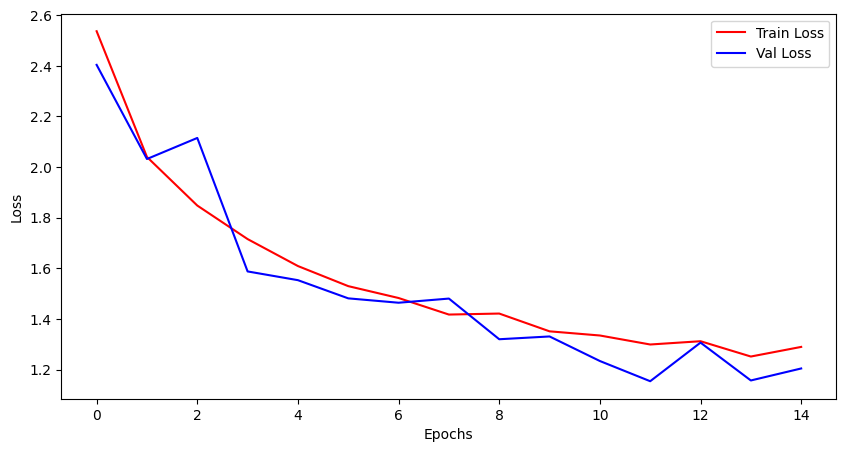

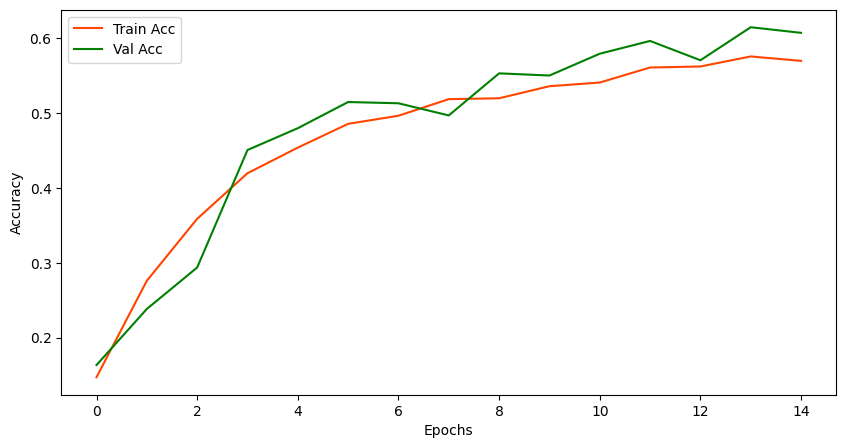

In [11]:
vgg_model = initialize_model("vgg", num_classes=len(classes))[0].to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg_model.parameters(), lr=config["learning_rate"]) 

train_vgg_model(vgg_model, device, train_loader, test_loader, criterion, optimizer, num_epochs=config["num_epochs"]) 

-------- VGG Evaluation Metrics --------
              precision    recall  f1-score   support

 Agriculture       0.59      0.50      0.54       160
     Airport       0.36      0.42      0.39       160
       Beach       0.82      0.58      0.68       160
        City       0.44      0.65      0.53       160
      Desert       0.75      0.96      0.84       160
      Forest       0.80      0.78      0.79       160
   Grassland       0.78      0.84      0.81       160
     Highway       0.31      0.17      0.22       160
        Lake       0.85      0.77      0.81       160
    Mountain       0.75      0.28      0.40       160
     Parking       0.68      0.88      0.77       160
        Port       0.62      0.94      0.75       160
     Railway       0.37      0.33      0.35       160
 Residential       0.55      0.68      0.61       160
       River       0.48      0.32      0.38       160

    accuracy                           0.61      2400
   macro avg       0.61      0.61      

Text(0.5, 1.0, 'Confusion Matrix for VGG16')

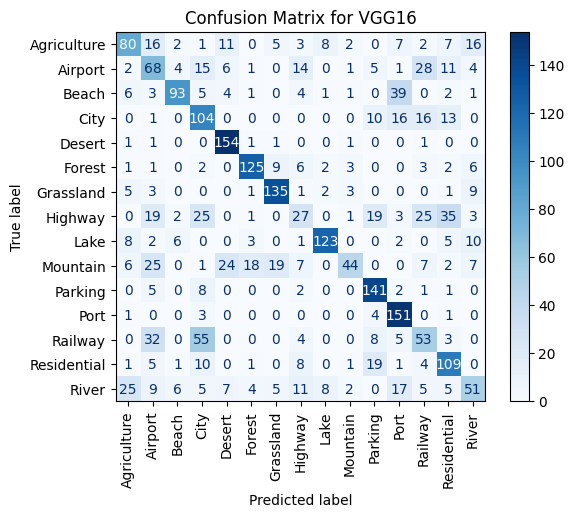

In [12]:
print("-------- VGG Evaluation Metrics --------")
evaluate_model(vgg_model, test_loader, device, class_names=classes)
plt.title(f"Confusion Matrix for VGG16")

In [13]:
import os  
import cv2  
import torch 
import numpy as np 
import matplotlib.pyplot as plt  
from collections import defaultdict
from torchcam.methods import GradCAM

def overlay_heatmap(img: np.ndarray, cam: np.ndarray, alpha: float = 0.5) -> np.ndarray:
    cam_uint8 = np.uint8(255 * cam)
    heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    if img.max() > 1.0:
        img = np.float32(img) / 255
    if img.shape[:2] != heatmap.shape[:2]:
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    overlayed = heatmap * alpha + img
    overlayed = overlayed / np.max(overlayed)
    return np.uint8(255 * overlayed)

def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def apply_gradcam_all_classes(model, device, dataloader, model_name="resnet", save_dir="gradcam_outputs"):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    if model_name == "resnet":
        target_layer = model.layer4[-1].conv2
    elif model_name == "vgg":
        target_layer = model.features[-1]
    else:
        raise ValueError("Unsupported model")

    cam_extractor = GradCAM(model, target_layer=target_layer)

    seen_classes = defaultdict(int)
    total_target_classes = 15
    class_id_to_name = [
        "Agriculture", "Airport", "Beach", "City", "Desert", "Forest", "Grassland", "Highway",
        "Lake", "Mountain", "Parking", "Port", "Railway", "Residential", "River"
    ]

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        for i in range(inputs.shape[0]):
            label = labels[i].item()
            if seen_classes[label] >= 1:
                continue 

            img_tensor = inputs[i].unsqueeze(0)
            output = model(img_tensor)
            class_idx = torch.argmax(output).item()

            cam_tensor = cam_extractor(class_idx=class_idx, scores=output)[0]
            cam = cam_tensor.cpu().numpy()
            if cam.ndim == 3:
                cam = cam[0]
            cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

            unnorm_img_tensor = unnormalize(img_tensor.squeeze(0).cpu(),
                                            mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225])
            raw_image = np.clip(unnorm_img_tensor.permute(1, 2, 0).numpy(), 0, 1)

            cam = cv2.resize(cam, (raw_image.shape[1], raw_image.shape[0]))
            result = overlay_heatmap(raw_image, cam)
            result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

            orig_img = np.uint8(raw_image * 255)
            orig_bgr = cv2.cvtColor(orig_img, cv2.COLOR_RGB2BGR)
            result_bgr = cv2.cvtColor(result_rgb, cv2.COLOR_RGB2BGR)

            cname = class_id_to_name[label]
            cv2.imwrite(os.path.join(save_dir, f"{cname}_original.png"), orig_bgr)
            cv2.imwrite(os.path.join(save_dir, f"{cname}_gradcam.png"), result_bgr)
            cv2.imwrite(os.path.join(save_dir, f"{cname}_compare.png"), np.hstack((orig_bgr, result_bgr)))

            fig, axs = plt.subplots(1, 2, figsize=(10, 4))
            axs[0].imshow(orig_img)
            axs[0].set_title(f"{cname} - Original")
            axs[0].axis('off')
            axs[1].imshow(result_rgb)
            axs[1].set_title(f"{cname} - GradCAM (Pred: {class_id_to_name[class_idx]})")
            axs[1].axis('off')
            plt.tight_layout()
            plt.show()

            seen_classes[label] += 1

        if len(seen_classes) >= total_target_classes:
            print("Grad-CAM DONE!")
            break

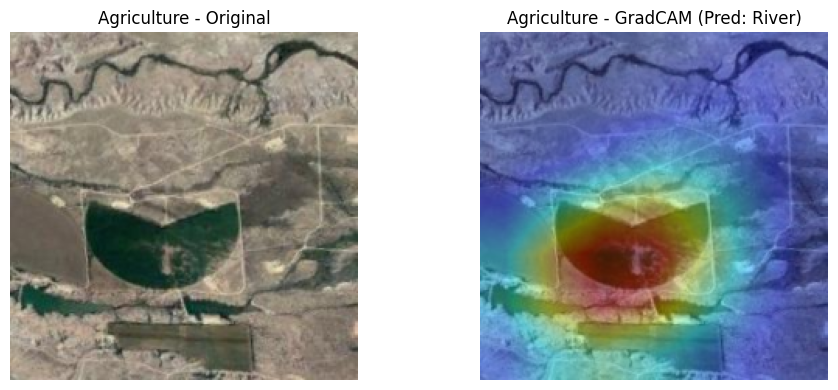

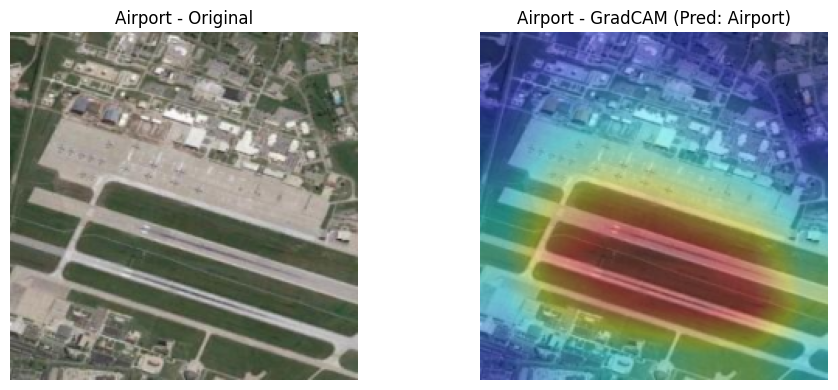

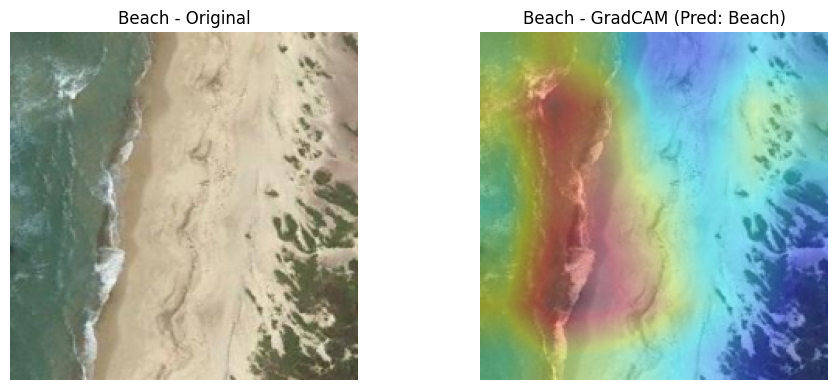

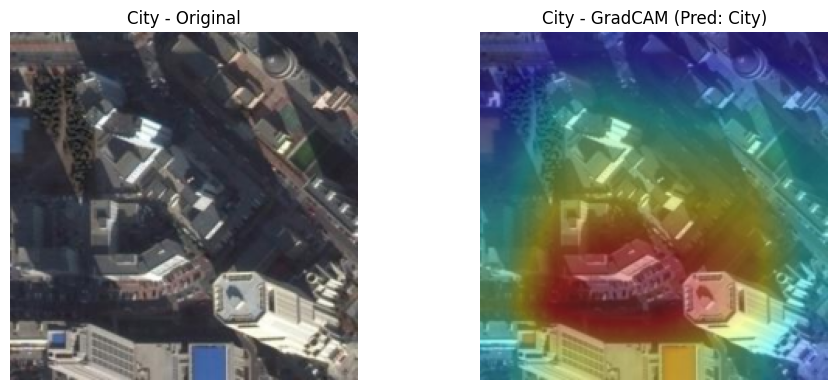

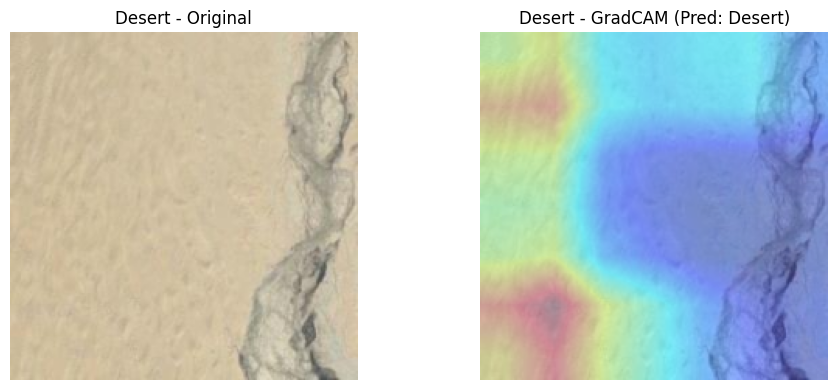

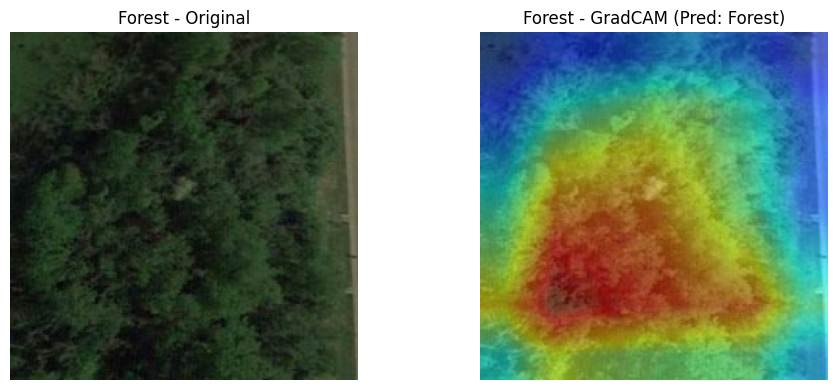

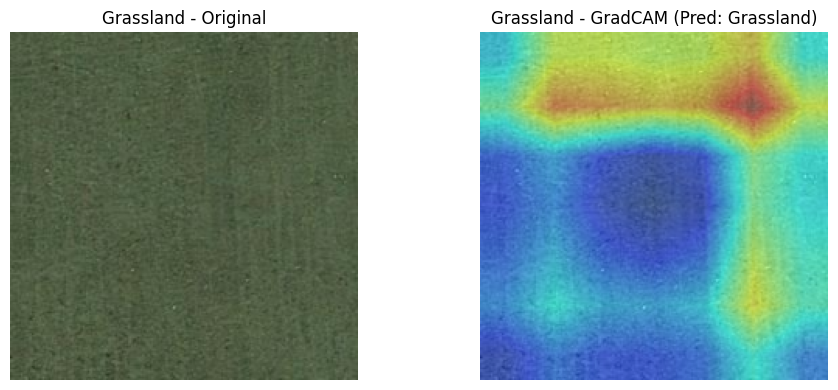

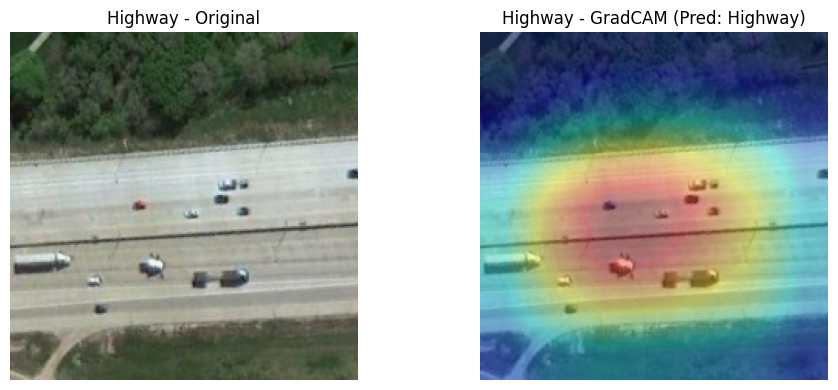

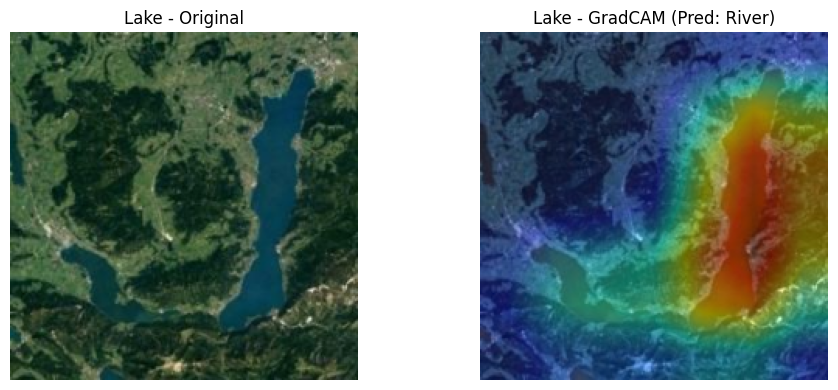

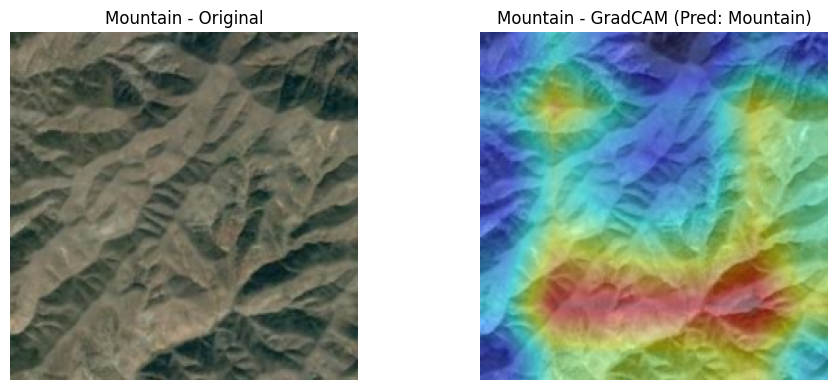

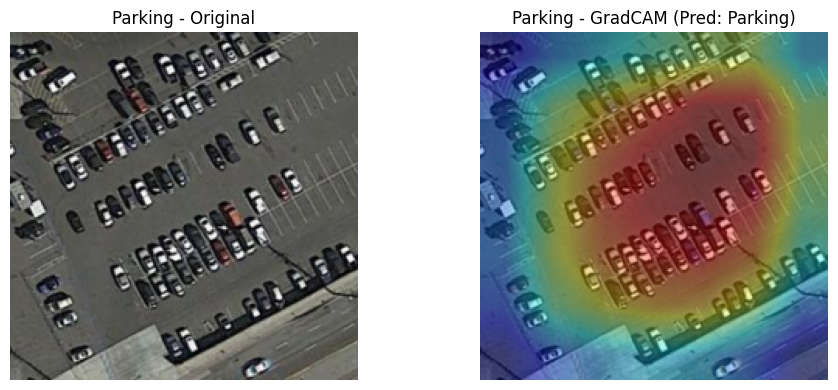

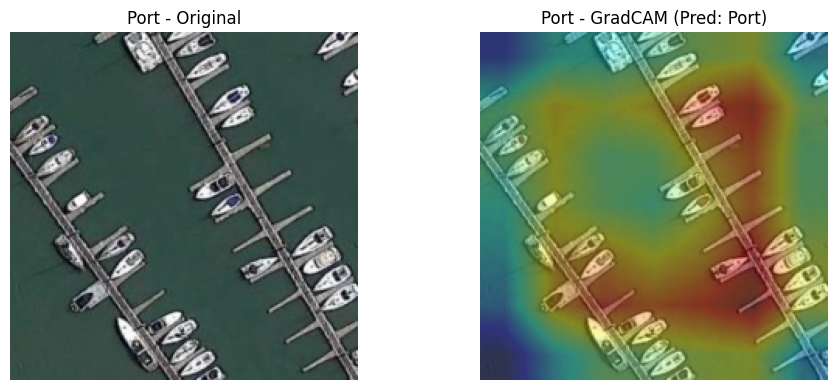

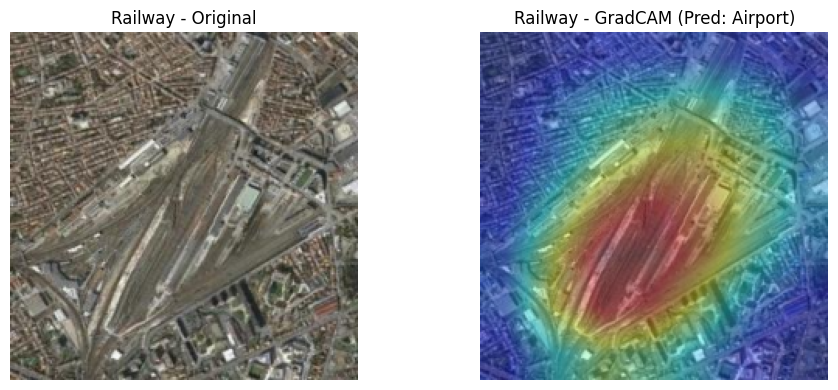

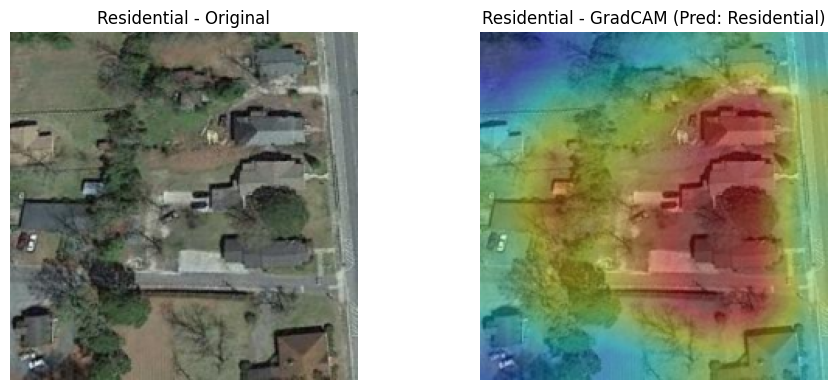

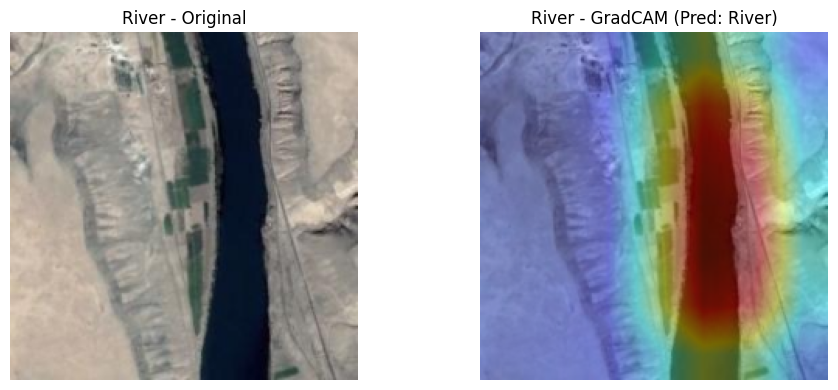

Grad-CAM DONE!


In [14]:
apply_gradcam_all_classes(model, device, test_loader, model_name="resnet")

In [17]:
from PIL import ImageDraw

class RandomOcclusion:
    def __init__(self, size=(60, 60)):
        self.size = size

    def __call__(self, img):
        w, h = img.size
        x0 = w // 2 - self.size[0] // 2
        y0 = h // 2 - self.size[1] // 2
        x1 = x0 + self.size[0]
        y1 = y0 + self.size[1]
        draw = ImageDraw.Draw(img)
        draw.rectangle([x0, y0, x1, y1], fill=(0, 0, 0))
        return img


In [18]:
from torchvision import transforms

occluded_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    RandomOcclusion(size=(60, 60)),  # make sure RandomOcclusion class is defined earlier
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


-------- ResNet under Occlusion --------
              precision    recall  f1-score   support

 Agriculture       0.02      0.01      0.01       160
     Airport       0.11      0.44      0.17       160
       Beach       0.00      0.00      0.00       160
        City       0.00      0.00      0.00       160
      Desert       0.00      0.00      0.00       160
      Forest       0.01      0.03      0.01       160
   Grassland       0.03      0.02      0.02       160
     Highway       0.10      0.09      0.09       160
        Lake       0.02      0.02      0.02       160
    Mountain       0.08      0.03      0.04       160
     Parking       0.00      0.00      0.00       160
        Port       0.00      0.00      0.00       160
     Railway       0.12      0.02      0.03       160
 Residential       0.04      0.11      0.06       160
       River       0.00      0.00      0.00       160

    accuracy                           0.05      2400
   macro avg       0.03      0.05      

/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

 Agriculture       0.36      0.32      0.34       160
     Airport       0.40      0.04      0.07       160
       Beach       0.18      0.21      0.19       160
        City       0.29      0.57      0.38       160
      Desert       0.00      0.00      0.00       160
      Forest       1.00      0.34      0.51       160
   Grassland       0.93      0.41      0.57       160
     Highway       0.27      0.02      0.04       160
        Lake       0.26      0.80      0.39       160
    Mountain       0.00      0.00      0.00       160
     Parking       0.62      0.82      0.71       160
        Port       0.25      0.97      0.40       160
     Railway       0.00      0.00      0.00       160
 Residential       0.59      0.35      0.44       160
       River       0.27      0.29      0.28       160

    accuracy                           0.34      2400
   macro avg       0.36      0.34      0.29      2400
weighted avg       0.36   

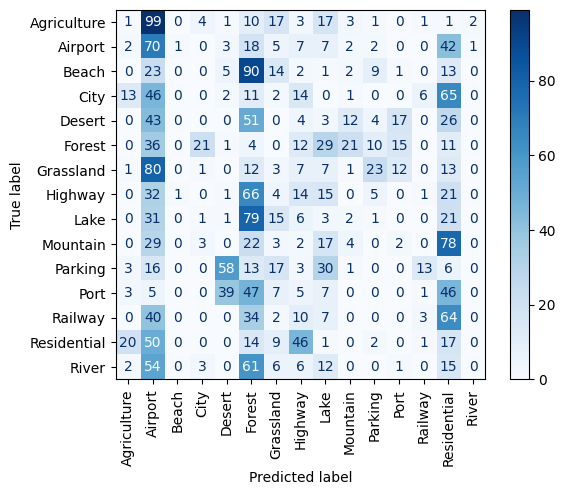

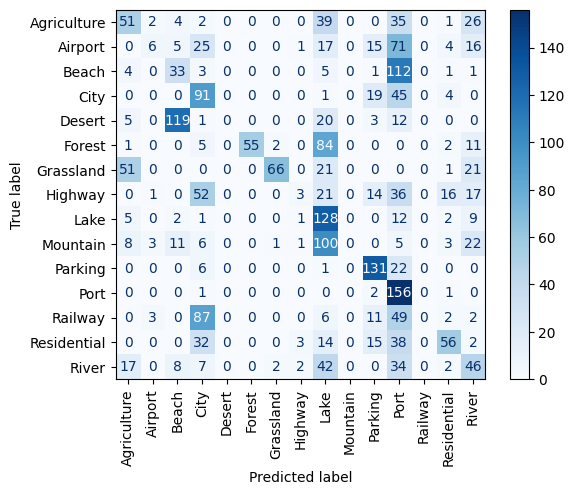

In [19]:
resnet_model = initialize_model("resnet", num_classes=len(classes))[0].to(device)
resnet_model.eval()

occluded_dataset = CustomDataset(test_images, test_labels, transform=occluded_test_transform)
occluded_loader = DataLoader(occluded_dataset, batch_size=32, shuffle=False)

print("-------- ResNet under Occlusion --------")
evaluate_model(resnet_model, occluded_loader, device, class_names=classes)

print("-------- VGG under Occlusion --------")
evaluate_model(vgg_model, occluded_loader, device, class_names=classes)


In [20]:
# Custom Transform: Add Gaussian Noise
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn_like(tensor) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'


In [21]:
# Custom Transform: Apply Gaussian Blur
from PIL import ImageFilter

class ApplyGaussianBlur(object):
    def __init__(self, radius=2):
        self.radius = radius

    def __call__(self, img):
        return img.filter(ImageFilter.GaussianBlur(self.radius))

    def __repr__(self):
        return self.__class__.__name__ + f'(radius={self.radius})'


In [22]:
# Gaussian Noise Test Transform
gaussian_noise_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    AddGaussianNoise(mean=0.0, std=0.1),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [23]:
# Gaussian Blur Test Transform
gaussian_blur_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    ApplyGaussianBlur(radius=2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [24]:
# Create DataLoaders with custom transforms
gaussian_noise_dataset = CustomDataset(test_images, test_labels, transform=gaussian_noise_transform)
gaussian_noise_loader = DataLoader(gaussian_noise_dataset, batch_size=32, shuffle=False)

gaussian_blur_dataset = CustomDataset(test_images, test_labels, transform=gaussian_blur_transform)
gaussian_blur_loader = DataLoader(gaussian_blur_dataset, batch_size=32, shuffle=False)


-------- ResNet under Gaussian Noise --------
              precision    recall  f1-score   support

 Agriculture       0.00      0.00      0.00       160
     Airport       0.15      0.12      0.14       160
       Beach       0.00      0.00      0.00       160
        City       0.00      0.00      0.00       160
      Desert       0.00      0.00      0.00       160
      Forest       0.02      0.18      0.04       160
   Grassland       0.02      0.01      0.02       160
     Highway       0.00      0.00      0.00       160
        Lake       0.00      0.00      0.00       160
    Mountain       0.00      0.00      0.00       160
     Parking       0.00      0.00      0.00       160
        Port       0.00      0.00      0.00       160
     Railway       0.10      0.06      0.08       160
 Residential       0.00      0.00      0.00       160
       River       0.07      0.01      0.01       160

    accuracy                           0.03      2400
   macro avg       0.02      0.03 

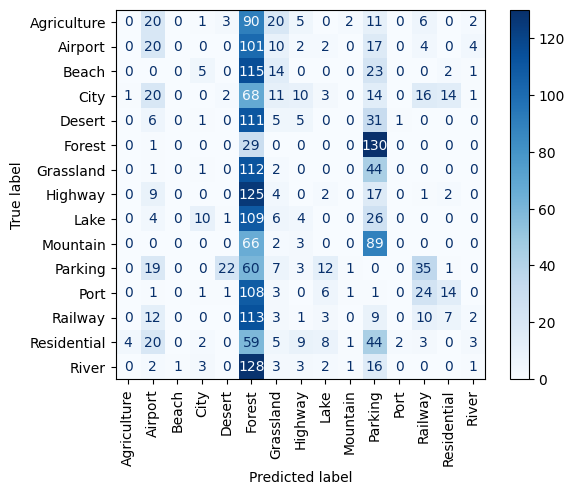

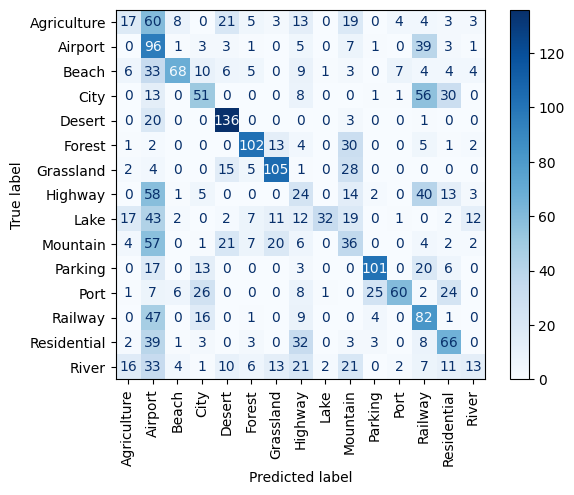

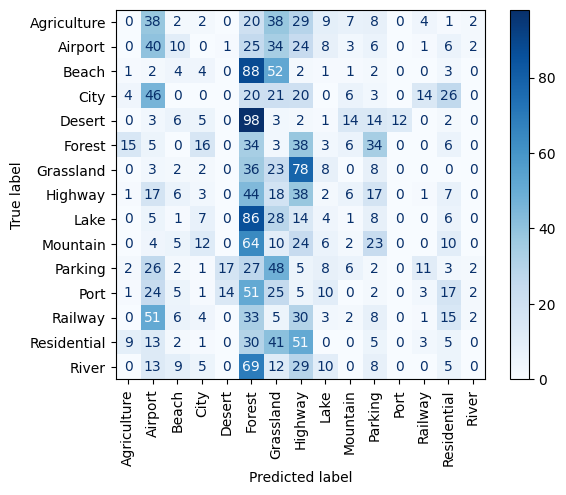

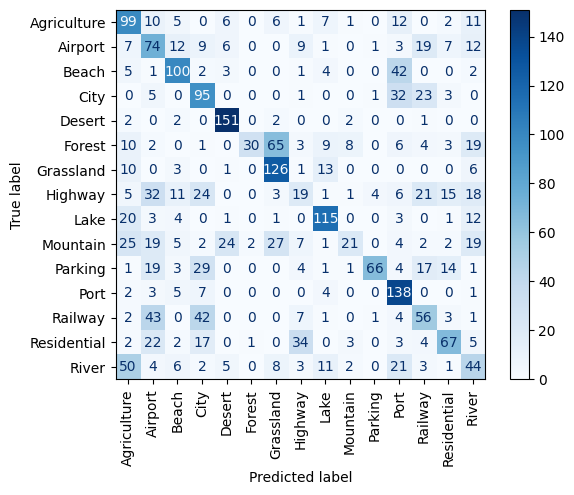

In [25]:
# Evaluate on Gaussian Noise
print("-------- ResNet under Gaussian Noise --------")
evaluate_model(resnet_model, gaussian_noise_loader, device, class_names=classes)

print("-------- VGG under Gaussian Noise --------")
evaluate_model(vgg_model, gaussian_noise_loader, device, class_names=classes)

# Evaluate on Gaussian Blur
print("-------- ResNet under Gaussian Blur --------")
evaluate_model(resnet_model, gaussian_blur_loader, device, class_names=classes)

print("-------- VGG under Gaussian Blur --------")
evaluate_model(vgg_model, gaussian_blur_loader, device, class_names=classes)
